In [1]:
import pandas as pd
import os
import glob

In [2]:
data_folder = '../data'
all_files = glob.glob(os.path.join(data_folder, "Subject_*_T1_Syllables_fixations.csv"))

In [3]:
num_fixation_data = []
all_aoi_sublines = set()

for file_path in all_files:
    filename = os.path.basename(file_path)
    subject_id = filename.split('_')[1]

    df = pd.read_csv(file_path)

    df = df.dropna(subset=['aoi_subline'])

    counts = df.groupby('aoi_subline').size()

    aoi_dict = counts.to_dict()
    all_aoi_sublines.update(aoi_dict.keys())

    row = {'subject_id': subject_id}
    row.update(aoi_dict)

    num_fixation_data.append(row)


In [4]:
raw_df = pd.DataFrame(num_fixation_data)
raw_df = raw_df.set_index('subject_id')
raw_df = raw_df.reindex(columns=sorted(all_aoi_sublines))
raw_df.reset_index(inplace=True)


In [5]:
raw_df.to_csv("number_of_fixation.csv", index=False)
print("Saved: number_of_fixation.csv")

Saved: number_of_fixation.csv


In [6]:
label_file = '../dyslexia_class_label.csv'
num_df = pd.read_csv('number_of_fixation.csv')
labels_df = pd.read_csv(label_file)
merged_df = pd.merge(num_df, labels_df[['subject_id', 'class_id']], on='subject_id', how='left')

subject_ids = merged_df['subject_id']
class_ids = merged_df['class_id']
features_df = merged_df.drop(columns=['subject_id', 'class_id'])

features_df = features_df.astype(float)

# Impute NaNs using class-wise means
for column in features_df.columns:
    for cls in merged_df['class_id'].unique():
        mask = class_ids == cls
        class_mean = features_df.loc[mask, column].mean()
        features_df.loc[mask & features_df[column].isna(), column] = class_mean

updated_df = pd.concat([subject_ids, features_df], axis=1)
updated_df.to_csv("updated_number_of_fixation.csv", index=False)
print("Saved: updated_number_of_fixation.csv")


Saved: updated_number_of_fixation.csv


In [7]:
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("updated_number_of_fixation.csv")
subject_ids = df['subject_id']
features = df.drop(columns=['subject_id'])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

scaled_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df.insert(0, 'subject_id', subject_ids)

scaled_df.to_csv("scaled_number_of_fixation.csv", index=False)
print("Saved: scaled_number_of_fixation.csv")

Saved: scaled_number_of_fixation.csv


In [9]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Load scaled features and labels
scaled_df = pd.read_csv('scaled_number_of_fixation.csv')
labels_df = pd.read_csv('../dyslexia_class_label.csv')

# Merge on subject_id
data = scaled_df.merge(labels_df[['subject_id', 'class_id']], on='subject_id')

# Features and labels
X = data.drop(columns=['subject_id', 'class_id']).values
y = data['class_id']

# Cross-validation setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store accuracy results
mlp_accs = {0.05: [], 0.1: [], 0.2: []}
knn_accs = {1: [], 3: [], 5: []}

for train_idx, val_idx in skf.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # Train MLP with different learning rates
    for lr in [0.05, 0.1, 0.2]:
        mlp = MLPClassifier(
            hidden_layer_sizes=(225, 112, 56),
            learning_rate_init=lr,
            alpha=0.2,  # Simulates dropout regularization
            max_iter=1000,
            random_state=42
        )
        mlp.fit(X_train, y_train)
        preds = mlp.predict(X_val)
        acc = accuracy_score(y_val, preds)
        mlp_accs[lr].append(acc)

    # Train kNN for k = 1, 3, 5
    for k in [1, 3, 5]:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_val)
        acc = accuracy_score(y_val, preds)
        knn_accs[k].append(acc)

# Print averaged results
print("\nAverage Accuracies over 5 folds only using first fixation:\n")

# MLP results
for lr in [0.05, 0.1, 0.2]:
    avg_acc = sum(mlp_accs[lr]) / len(mlp_accs[lr])
    print(f"MLP (lr={lr}): {avg_acc:.2%}")

# kNN results
for k in [1, 3, 5]:
    avg_acc = sum(knn_accs[k]) / len(knn_accs[k])
    print(f"kNN (k={k}): {avg_acc:.2%}")



Average Accuracies over 5 folds only using first fixation:

MLP (lr=0.05): 55.71%
MLP (lr=0.1): 68.57%
MLP (lr=0.2): 61.43%
kNN (k=1): 67.14%
kNN (k=3): 60.00%
kNN (k=5): 60.00%


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Logistic Regression
logreg_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
logreg_scores = cross_val_score(logreg_pipeline, X, y, cv=cv, scoring='accuracy')
print("Logistic Regression Accuracy:", logreg_scores.mean())

# SVM (Linear Kernel)
svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='linear', C=1.0))
svm_scores = cross_val_score(svm_pipeline, X, y, cv=cv, scoring='accuracy')
print("SVM Accuracy:", svm_scores.mean())

# Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
rf_scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy')
print("Random Forest Accuracy:", rf_scores.mean())

# Ridge Classifier
ridge_pipeline = make_pipeline(StandardScaler(), RidgeClassifier(alpha=1.0))
ridge_scores = cross_val_score(ridge_pipeline, X, y, cv=cv, scoring='accuracy')
print("Ridge Classifier Accuracy:", ridge_scores.mean())

# Optional: Feature selection
from sklearn.pipeline import Pipeline

feature_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=30)),  
    ('clf', LogisticRegression(max_iter=1000))
])
fs_scores = cross_val_score(feature_pipeline, X, y, cv=cv, scoring='accuracy')
print("Feature-selected Logistic Regression Accuracy:", fs_scores.mean())



Logistic Regression Accuracy: 0.7000000000000001
SVM Accuracy: 0.6142857142857143
Random Forest Accuracy: 0.7714285714285715
Ridge Classifier Accuracy: 0.6142857142857143
Feature-selected Logistic Regression Accuracy: 0.7571428571428572


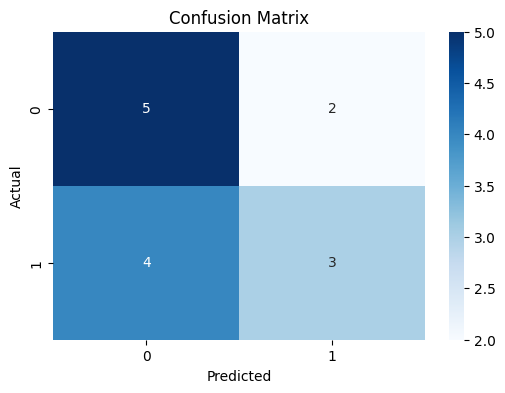

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.71      0.62         7
           1       0.60      0.43      0.50         7

    accuracy                           0.57        14
   macro avg       0.58      0.57      0.56        14
weighted avg       0.58      0.57      0.56        14



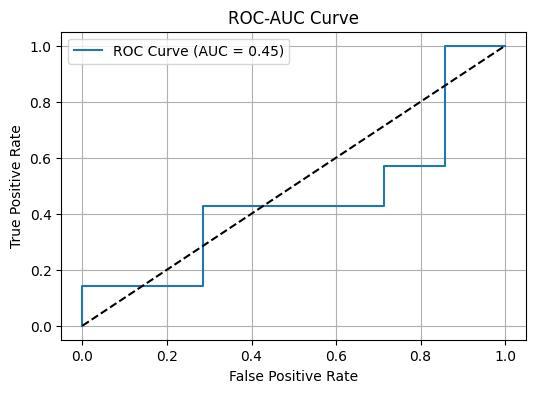

Model saved as 'voting_classifier_dyslexia.pkl'
Best SVM Params: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Best SVM Accuracy: 0.8


In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Train-test split for visualization purposes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define models
logreg = LogisticRegression(max_iter=1000)
svm = SVC(kernel='linear', probability=True)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Voting Classifier
voting = VotingClassifier(estimators=[
    ('lr', logreg), 
    ('svm', svm), 
    ('rf', rf)
], voting='soft')

# Train and evaluate
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)
y_prob = voting.predict_proba(X_test)[:, 1]

# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Save model
joblib.dump(voting, "voting_classifier_dyslexia.pkl")
print("Model saved as 'voting_classifier_dyslexia.pkl'")

# Optional: Hyperparameter Tuning for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
grid_svm = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy')
grid_svm.fit(X, y)
print("Best SVM Params:", grid_svm.best_params_)
print("Best SVM Accuracy:", grid_svm.best_score_)
